## Unsupervised Anomaly Detection

In this settings, the class labels of the training set are not available. The true labels are usually ignored during training so as to reflect a real-world instance. For this particular problem, we use a number of unsupervised classification models to predict the true labels for each record. These models are: 

1. Isolation Forest
2. Cluster-Based Local Outlier Factor
3. Principal Component Analysis (PCA)
4. Elliptic Envelope 

Additionally, the business have to validate the predicted results due to the absence of ground truth. However, in our case, the predicted labels were validated with the true labels, and the results below show that the unsupervised models predicted so many false positives with perfect recall. 

In [2]:
%matplotlib inline

# Filter warnings
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'font.size': 15})

In [3]:
# Import custom classes
%run -i '../src/transfxns.py'
%run -i '../src/unsup_ml.py'

In [4]:
# Instantiate the classes
transfxn = TransformationPipeline()
model = UnsupervisedModels()
scaler = StandardScaler()

In [5]:
# Load Data
df = pd.read_csv('kdd99-unsupervised-ad.csv', header = None)
print("Data size:", df.shape) # print data size
df.columns = ['v_{}'.format(i) for i in range(30)] # column names
#df.head()

Data size: (620098, 30)


### Categorical variables encoded as integers

In [6]:
# Convert to string
cols = ['v_6', 'v_7', 'v_8', 'v_9']
for i, val in enumerate(cols):
    df[val] = df[val].astype('O')

### Drop class label 

In the context of unsupervised anomaly detection problems, we typically don't have access to class labels. However, for the purpose of evaluating unsupervised models, we'll use the provided class labels if available. It's important to note that this evaluation approach isn't feasible in real-world scenarios.

In [7]:
 # Map to binary and save for later use
y_true = (df.v_29.map({'n':0, 'o':1})).values

In [8]:
# Drop class label
X = df.drop('v_29', axis =1)

In [9]:
# Transform and scale data
X_scaled, _, feat_nm = transfxn.preprocessing(X, X)

In [10]:
print('Data size after pre-processing:', X_scaled.shape)

Data size after pre-processing: (620098, 33)


### Unspervised Models

#### 1. Isolation Forest 

It works by isolating anomalies in the data by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. This process is repeated recursively to create isolation trees. Anomalies are typically isolated closer to the root of the trees, as they require fewer splits to be isolated. By averaging the path lengths of anomalies across multiple trees, the algorithm can identify instances that have shorter average path lengths, indicating that they are anomalies. 

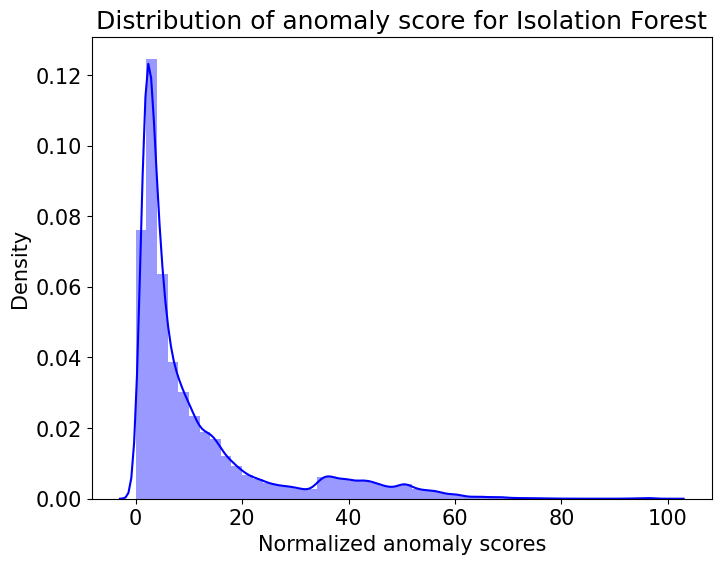

In [14]:
# Train model
if_scores, if_y_pred = model.iforest(X_scaled, n_estimators = 100, random_state= 42)

# Add anomaly score to the data
if_df = df.copy()
if_df['anomaly_score'] = if_scores

# Plot anomaly score distribution
model.plot_dist(if_df.anomaly_score, color = 'b', 
                title = 'Distribution of anomaly score for Isolation Forest')

#### 1.a. Evaluating metric with raw predicted labels

In [15]:
# Evaluating metric with raw predicted labels
model.eval_metric(y_true, if_y_pred, model_nm = 'Isolation Forest')

Test predictions for Isolation Forest
------------------------------------------------------------
Accuracy:  0.907542
AUROC: 0.912413
AUPRC: 0.015347
Predicted classes: [0 1]
Confusion matrix:
 [[561800  57246]
 [    87    965]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    619046
           1       0.02      0.92      0.03      1052

    accuracy                           0.91    620098
   macro avg       0.51      0.91      0.49    620098
weighted avg       1.00      0.91      0.95    620098

------------------------------------------------------------


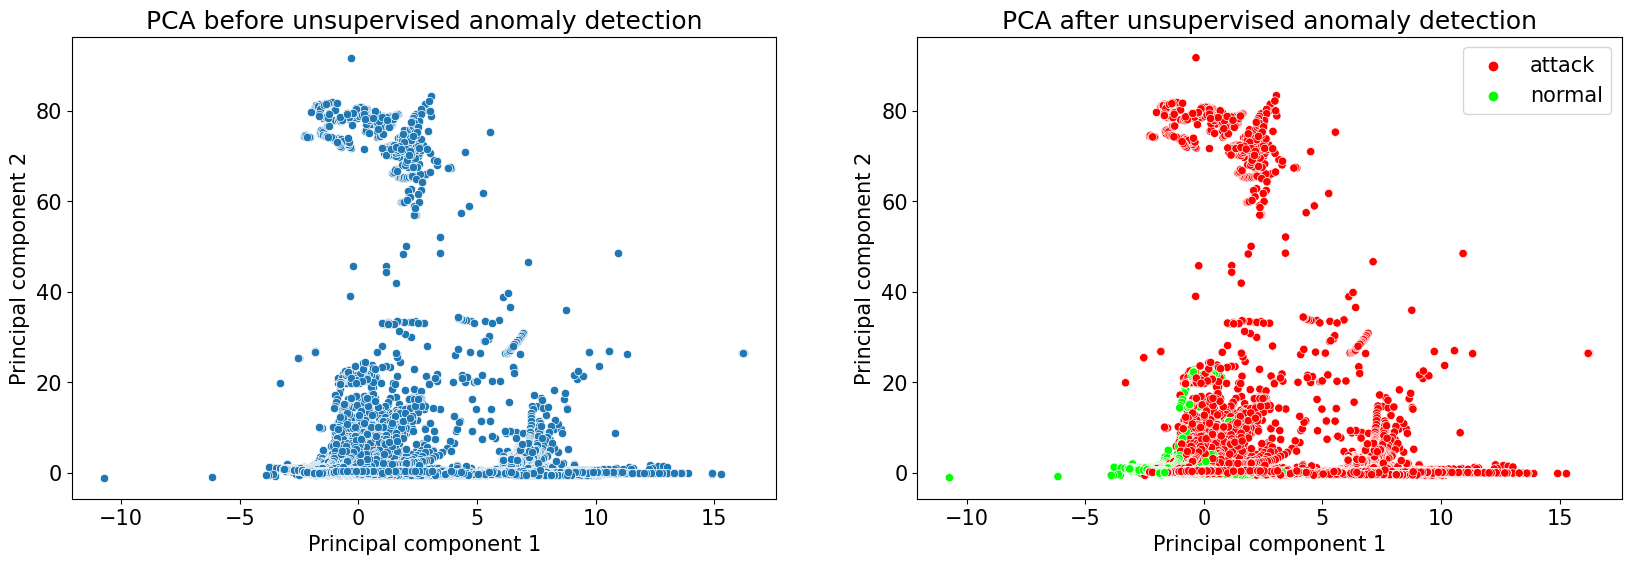

In [16]:
# PCA plot with raw predicted labels
if_y_pred = pd.Series(if_y_pred).map({0:'normal',1: 'attack'})
transfxn.pca_plot(scaler.fit_transform(X), if_y_pred, palette = ['r', 'lime'])

#### 1.b. Evaluating metric with tunable threshold

In [17]:
# Evaluating metric with threshold predicted labels
if_th_pred = np.where(if_scores >= 90, 1, 0)
model.eval_metric(y_true, if_th_pred, model_nm = 'Isolation Forest with threshold >= 90')

Test predictions for Isolation Forest with threshold >= 90
------------------------------------------------------------
Accuracy:  0.999071
AUROC: 0.726710
AUPRC: 0.453401
Predicted classes: [0 1]
Confusion matrix:
 [[619045      1]
 [   575    477]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    619046
           1       1.00      0.45      0.62      1052

    accuracy                           1.00    620098
   macro avg       1.00      0.73      0.81    620098
weighted avg       1.00      1.00      1.00    620098

------------------------------------------------------------


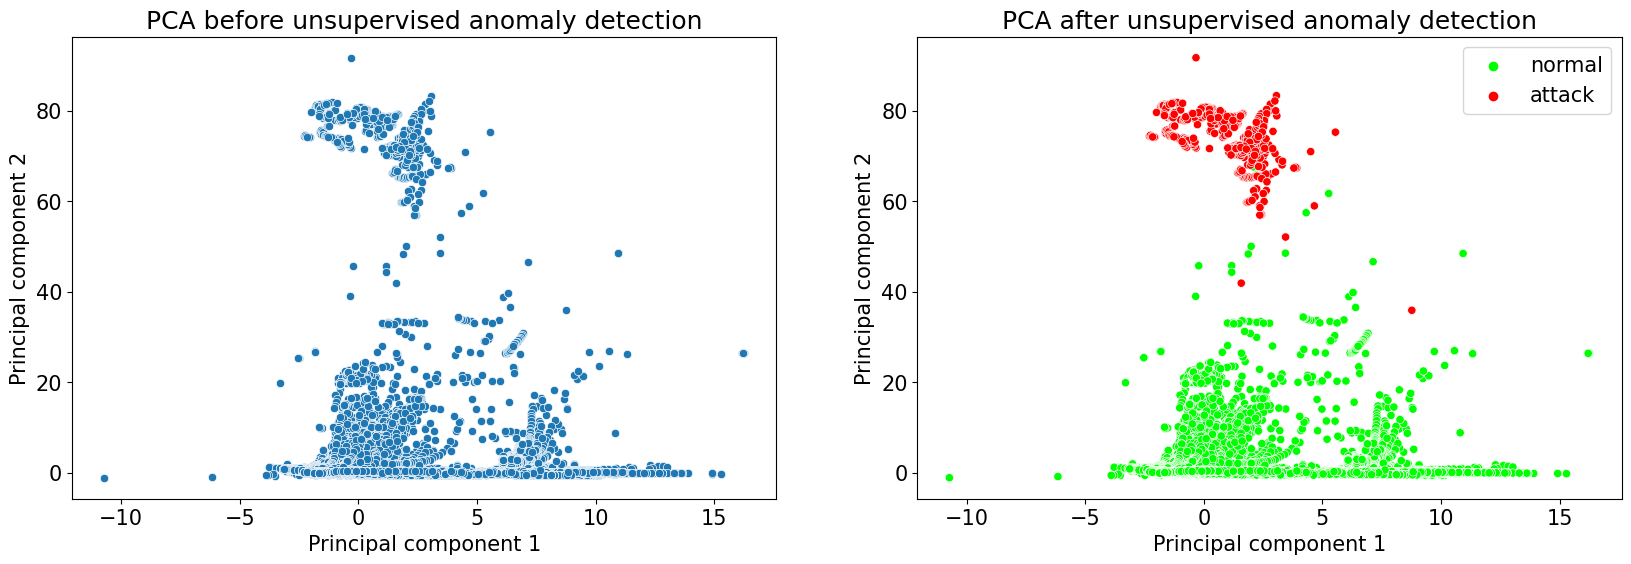

In [18]:
# PCA plot with raw predicted labels
if_th_pred = pd.Series(if_th_pred).map({0:'normal',1: 'attack'})
transfxn.pca_plot(scaler.fit_transform(X), if_th_pred, palette = ['lime', 'r'])

#### 2. Cluster-Based Local Outlier Factor 

It is an anomaly detection algorithm that extends the Local Outlier Factor (LOF) method by leveraging clustering techniques. LOF calculates the local density deviation of a data point with respect to its neighbors, identifying outliers based on their deviation from the local density of surrounding points.

CBLOF partitions the data into clusters using a clustering algorithm (e.g., k-means) and then applies the LOF algorithm within each cluster. By doing so, CBLOF can capture outliers both globally and locally within each cluster, providing a more comprehensive analysis of anomalies. This approach is particularly useful for datasets with complex structures where traditional density-based methods may struggle to detect outliers effectively.

CBLOF assigns anomaly scores to each data point, with higher scores indicating a higher likelihood of being an outlier. By setting a threshold on the anomaly scores, users can identify and flag potential anomalies in their data.

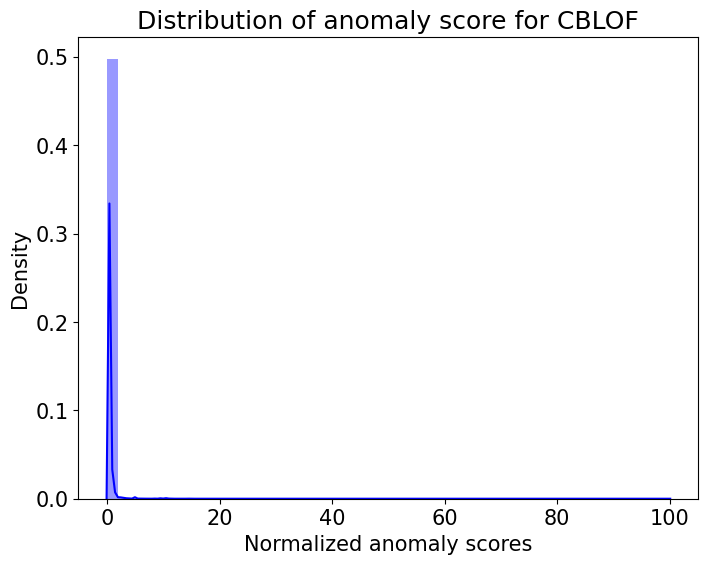

In [11]:
# Train model
cblof_scores, cblof_y_pred = model.cblof(X_scaled, contamination = 0.1, random_state = 42)

# Add anomaly score to the data
cblof_df = df.copy()
cblof_df['anomaly_score'] = cblof_scores

# Plot anomaly score distribution
model.plot_dist(cblof_df.anomaly_score, color = 'b',
                title = 'Distribution of anomaly score for CBLOF')

In [12]:
# Evaluating metric with raw predicted labels
model.eval_metric(y_true, cblof_y_pred, model_nm = 'Cluster-Based Local Outlier Factor')

Test predictions for Cluster-Based Local Outlier Factor
------------------------------------------------------------
Accuracy:  0.901696
AUROC: 0.950765
AUPRC: 0.016965
Predicted classes: [0 1]
Confusion matrix:
 [[558088  60958]
 [     0   1052]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    619046
           1       0.02      1.00      0.03      1052

    accuracy                           0.90    620098
   macro avg       0.51      0.95      0.49    620098
weighted avg       1.00      0.90      0.95    620098

------------------------------------------------------------


#### 3. PCA

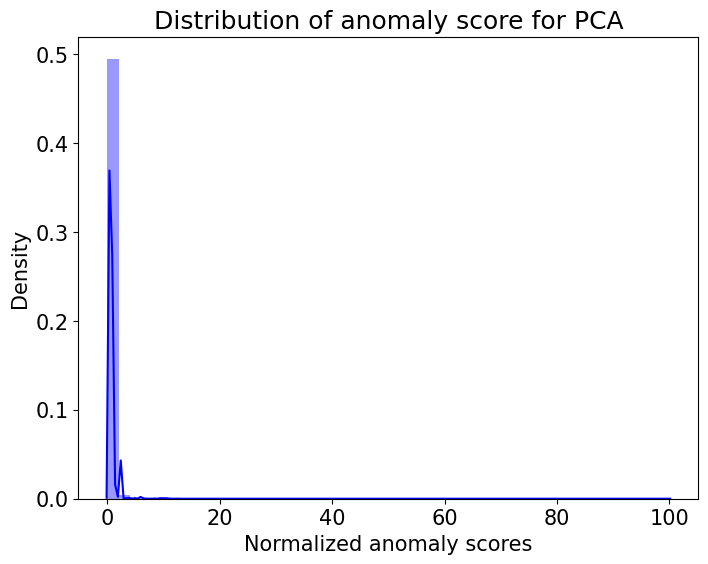

In [13]:
# Train model
pca_scores, pca_y_pred = model.pca(X_scaled, n_components = None, contamination = 0.1)

# Add anomaly score to the data
pca_df = df.copy()
pca_df['anomaly_score'] = pca_scores

# Plot anomaly score distribution
model.plot_dist(pca_df.anomaly_score, color = 'b', 
                title = 'Distribution of anomaly score for PCA')

In [14]:
# Evaluating metric with raw predicted labels
model.eval_metric(y_true, pca_y_pred, model_nm = 'Principal Component Analysis')

Test predictions for Principal Component Analysis
------------------------------------------------------------
Accuracy:  0.901696
AUROC: 0.950765
AUPRC: 0.016965
Predicted classes: [0 1]
Confusion matrix:
 [[558088  60958]
 [     0   1052]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    619046
           1       0.02      1.00      0.03      1052

    accuracy                           0.90    620098
   macro avg       0.51      0.95      0.49    620098
weighted avg       1.00      0.90      0.95    620098

------------------------------------------------------------


#### 4. Elliptic Envelope

 It assumes that the normal data points are generated from a Gaussian distribution, while outliers deviate significantly from this distribution. The algorithm fits an ellipse to the central data points, considering them as the inliers, and identifies observations lying outside this ellipse as outliers.

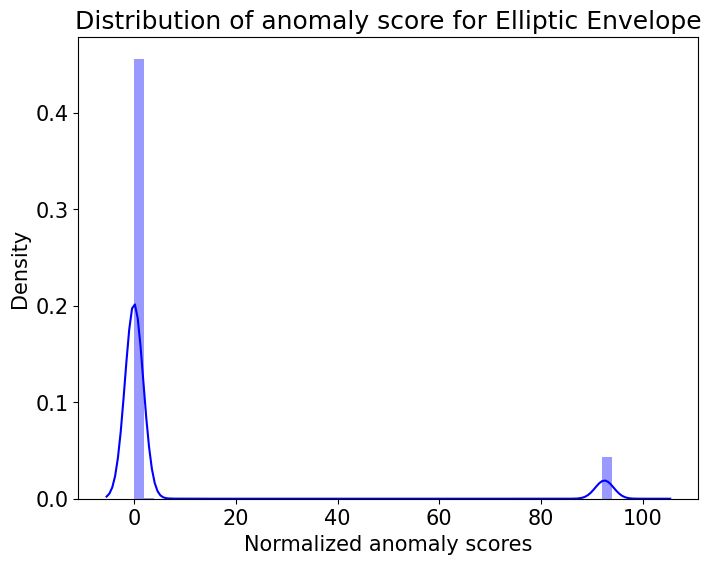

In [15]:
# Train model
ellip_scores, ellip_y_pred = model.cov(X_scaled, contamination = 0.1, random_state = 42)

# Add anomaly score to the data
ellip_df = df.copy()
ellip_df['anomaly_score'] = ellip_scores

# Plot anomaly score distribution
model.plot_dist(ellip_df.anomaly_score, color = 'b', 
                title = 'Distribution of anomaly score for Elliptic Envelope')

In [16]:
# Evaluating metric with raw predicted labels
model.eval_metric(y_true, ellip_y_pred, model_nm = 'Elliptic Envelope')

Test predictions for Elliptic Envelope
------------------------------------------------------------
Accuracy:  0.899522
AUROC: 0.629878
AUPRC: 0.003277
Predicted classes: [0 1]
Confusion matrix:
 [[557414  61632]
 [   674    378]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    619046
           1       0.01      0.36      0.01      1052

    accuracy                           0.90    620098
   macro avg       0.50      0.63      0.48    620098
weighted avg       1.00      0.90      0.95    620098

------------------------------------------------------------
